# Panorama Mosaic

Aluno: Arthur Souto Lima  
Mat.: 2018055113

## Imports e Funções Auxiliares

In [1]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def show(cv2_img,title=""):
    """
    Show an OpenCV BGR image

    Parameters:
        cv2_img: an BGR image
        title: (optional) title to be plotted above
    
    Returns:
        None
    """
    if title:
        plt.title(title)
    plt.imshow(cv.cvtColor(cv2_img, cv.COLOR_BGR2RGB))
    plt.show()

In [3]:
def image_resize(image, width=None, height=None, inter=cv.INTER_AREA):
    """
    Resize an image keeping aspect ratio
    
    Parameters:
        image: image to be resized
        width: (optional) resized width
        height: (optional) resized height
        inter: interpolation method. Defaults to cv.INTER_AREA
    
    Source:
    https://stackoverflow.com/questions/44650888/resize-an-image-without-distortion-opencv
    """
    # initialize the dimensions of the image to be resized and
    # grab the image size
    dim = None
    (h, w) = image.shape[:2]

    # if both the width and height are None, then return the
    # original image
    if width is None and height is None:
        return image

    # check to see if the width is None
    if width is None:
        # calculate the ratio of the height and construct the
        # dimensions
        r = height / float(h)
        dim = (int(w * r), height)

    # otherwise, the height is None
    else:
        # calculate the ratio of the width and construct the
        # dimensions
        r = width / float(w)
        dim = (width, int(h * r))

    # resize the image
    resized = cv.resize(image, dim, interpolation = inter)

    # return the resized image
    return resized

## Detecção e Descrição de Keypoints

Para poder fazer os mosaicos, precisamos detectar e descrever os keypoints das imagens. A função abaixo computa essas informações necessárias usando algum método especificado. Há um número máximo de keypoints que podem ser retornados por questões de desempenho, visto que posteriormente faremos o casamento usando força-bruta, logo uma quantidade muito grande inviabiliza os procedimentos

In [4]:
def detectAndDescribe(img, method, n_keypoints=5000):
    """
    Detect and describe keypoints in passed image using said method.
    
    Parameters:
        img: image where we'll detect the keypoints
        method: method for describing the keypoints
        n_keypoints: maximum number of found keypoints. Defaults to 5000
    Returns:
        kpts: list of keypoints
        descriptors: list of descriptors to these keypoints
    
    Adapted from:
    Thalles Silva, Image Panorama Stitching with OpenCV (2019)
    OpenCV, BRIEF
    """
    
    kpts, descriptors = None, None
    if method == 'sift':
        # Uses SIFT detector and extractor
        sift = cv.xfeatures2d.SIFT_create(n_keypoints)
        kpts, descriptors = sift.detectAndCompute(img, None)
        
    elif method == 'brief':
        # Uses SIFT detector and BRIEF extractor
        sift = cv.xfeatures2d.SIFT_create(n_keypoints)
        brief = cv.xfeatures2d.BriefDescriptorExtractor_create()
        
        # Find keypoints via SIFT detector
        kp = sift.detect(img,None)
        
        # Compute the descriptors with BRIEF
        kpts, descriptors = brief.compute(img, kp)
    
    return kpts, descriptors

In [5]:
def drawKeypoints(img, kpts, features):
    """
    Plots an image with its keypoints
    
    Parameters: 
        img: image to serve as a background to the plot
        kpts: image keypoints
        features: keypoints' description 
    Returns:
        None
    """
    plt.imshow(cv.drawKeypoints(img,kpts,None,color=(0,255,0)))

## Casamento de Keypoints

Como já comentado, para que seja possível mesclar as imagens é necessário que seja feita um casamento entre os keypoints encontrados. Aqui usaremos apenas o método força-bruta. Também como já citado, por conta dele deve-se limitar a quantidade de keypoints reportados numa única imagem.

In [6]:
def matchKeyPointsBF(featuresA, featuresB, prints=False):
    """
    Matches keypoints using Brute-Force matcher
    
    Parameters:
        featuresA: descriptors from first image
        featuresB: descriptors from second image
        prints: prints some progress information if true
    Returns:
        rawMatches: unordered list of matches
        
    Adapted from: 
    Thalles Silva, Image Panorama Stitching with OpenCV (2019)
    """
    # Creates Brute-Force matcher using Euclidean Distance to find matches
    # crossCheck allows us to have a more robust matching
    bf = cv.BFMatcher(cv.NORM_L2, crossCheck=True)
        
    # Match descriptors.
    best_matches = bf.match(featuresA,featuresB)
    
    # Sort the features in order of distance.
    # The points with small distance (more similarity) are ordered first in the vector
    rawMatches = sorted(best_matches, key = lambda x:x.distance)
    
    # Print how many matches, if needed
    if (prints): 
        print("Raw matches (Brute force):", len(rawMatches))

    return rawMatches

In [7]:
def drawMatches(img1, kps1, img2, kps2, matches, qtd=100):
    """
    Plots some resulting matches between keypoints
    
    Parameters:
        img1: first image, to serve as background
        kps1: first image's keypoints
        img2: second image, to serve as background
        kps2: second image's keypoints
        matches: list of matches between these keypoints
        qtd: how many matches will be plotted. Defaults to 100. 
             Must be less than number of matches
    Returns:
        None
    
    Adapted from: 
    Thalles Silva, Image Panorama Stitching with OpenCV (2019)
    """
    if (qtd > len(matches)):
        raise "Too few matches to plot"
    
    fig = plt.figure(figsize=(20,8))
    img = cv.drawMatches(img1, kps1, img2, kps2,
                         matches[:qtd], None,
                         flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
    show(img)

## Homografia

Com os keypoints já descritos e casados, utilizamos a função do OpenCV _findHomography_ para encontrar a matriz de transformação. Com ela, será possível implementar a _warpPerspective_ para criar os mosaicos

In [8]:
def getHomography(kpsA, kpsB, featuresA, featuresB, matches, reprojThresh):
    """
    Creates homography matrix using RANSAC to more robust estimation
    
    Parameters:
        kpsA: first image's keypoints
        kpsB: second image's keypoints
        featuresA: first image's keypoints
        featuresB: second image's keypoints
        matches: list of keypoint matches
        reprojThresh: reprojection threshold for homography OpenCV function
    
    Returns:
        H: homography matrix
        status: if the algorithm was capable of finding a valid homography
        
    Adapted from:
    Thalles Silva, Image Panorama Stitching with OpenCV (2019)
    """
    # Convert the keypoints to numpy arrays
    kpsA = np.float32([kp.pt for kp in kpsA])
    kpsB = np.float32([kp.pt for kp in kpsB])
    
    # Construct the two sets of points
    ptsA = []
    ptsB = []
    for m in matches:
        ptsA.append(np.float32(kpsA[m.queryIdx]))
        ptsB.append(np.float32(kpsB[m.trainIdx]))
    ptsA, ptsB = np.array(ptsA), np.array(ptsB)
    
    # Estimate the homography between the sets of points
    H, status = cv.findHomography(ptsA, ptsB, cv.RANSAC, reprojThresh)

    return H, status

## _warpPerspective_

Inicialmente, vamos trabalhar com uma _warpPerspective_ "simples", que ou faz a média ou dá a preferência para uma das imagens. 

In [9]:
def blendAverage(pix1, pix2):
    """
    Blends pixel1 and pixel2 by averaging them
    
    Parameters:
        pix1: first pixel
        pix2: second pixel
    Returns:
        avg: averaged pixel
    """
    if (np.sum(pix1) == 0):
        # Zero pixel, use only other one
        return pix2
    elif (np.sum(pix2) == 0):
        # Zero pixel, use only other one
        return pix1
    else:
        return 0.5*pix1 + 0.5*pix2

In [10]:
def blendPreferBase(pix1, pix2):
    """
    Blends pixel1 and pixel2 by prefering the first one
    if it is non-zero
    
    Parameters:
        pix1: first pixel
        pix2: second pixel
    Returns:
        avg: averaged pixel
    """
    if (np.sum(pix1) == 0):
        # Zero pixel, use only other one
        return pix2
    else:
        # Prefer the first one
        return pix1

In [11]:
def blendPreferOther(pix1, pix2):
    """
    Blends pixel1 and pixel2 by prefering the second one
    if it is non-zero
    
    Parameters:
        pix1: first pixel
        pix2: second pixel
    Returns:
        avg: averaged pixel
    """
    if (np.sum(pix2) == 0):
        # Zero pixel, use only other one
        return pix1
    else:
        # Prefer the first one
        return pix2

In [33]:
def warpPerspectiveSimple(src, dest, H, method, prints=False):
    """
    Performs warpPerspective from source image to destination.
    Blends intersecting pixels using a specific method.
    
    Parameters:
        src: source image
        dest: destination image
        H: homography matrix to transform src into dest
        method: blending method to be used in the intersection area
        prints: prints some progress information if true 
    Returns:
        dest: blended images
    """
    
    if (dest is None):
        # destination is a blank image
        dest = np.zeros((src.shape[0]*2, src.shape[1]*2, src.shape[2]), 
                         dtype=np.uint8)
    
    # In order to avoid interpolation problems, 
    # we'll warp from destination to find correspondent
    # pixels in source image
    
    _, H1 = cv.invert(H)    # We'll need H^-1 to do this
    
    for i in range(dest.shape[0]):
        for j in range(dest.shape[1]):
            res = np.dot(H1, [j,i,1])  # j is for columns <-> equivalent to x
                                       # i is for rows    <-> equivalent to y
            i2,j2,_ = (res/res[2]).astype(int)  # De-homogenizing
            
            if i2 >= 0 and i2 < src.shape[1]:
                if j2 >= 0 and j2 < src.shape[0]:
                    pixel_src = src[j2,i2]
                    pixel_dest = dest[i,j]
                    
                    # Blending function:
                    if (method == "average"):
                        dest[i,j] = blendAverage(pixel_src, pixel_dest)
                    elif (method == "base"):
                        dest[i,j] = blendPreferBase(pixel_src, pixel_dest)
                    elif (method == "other"):
                        dest[i,j] = blendPreferOther(pixel_src, pixel_dest)
                    else:
                        raise "Invalid Blending Method"
    return dest

## Feathering

Para fazer o efeito de feathering, são necessárias algumas funções auxiliares. Principalmente para criar máscaras que servirão de pesos para as imagens. A _warpPerspective_ usada nesses casos é a _warpPerspectiveSimple_ já descrita acima. Faremos a mistura (blending) utilizando as máscaras, após a transformação, ao invés de fazer durante o warping como foram os casos dos outros tipos de blending.

In [13]:
def distMask(img):
    """
    Computes pixel distance to borders and 
    creates a mask with this information
    
    Parameters:
        img: image to be processed
    Return:
        result: mask
    """
    result = np.zeros(img.shape)
    
    maxRow = img.shape[0]
    maxCol = img.shape[1]
    for i in range(maxRow):
        for j in range(maxCol):
            # Vertical Distance
            distTop = i
            distBot = (maxRow-1) - i
            distRow = min(distTop, distBot)
            
            # Horizontal Distance
            distLft = j
            distRgt = (maxCol-1) - j
            distCol = min(distLft, distRgt)
            
            # Total Distance
            dist = min(distRow, distCol)
            result[i][j] = dist + 1   # So we don't have zeros
    cv.normalize(result, result, 1, 255, cv.NORM_MINMAX)
    result = result / 255
    # result = np.uint8(result)
    return result

In [34]:
def distMasks(base_img_unpadded, other_img_unflipped, H):
    """
    Creates distance-to-border-based masks for both images, given also the homography matrix
    
    Parameters:
        base_img_unpadded: base image (not to be transformed) without padding
        other_img_unflipped: image to be transformed, not yet transformed
        H: homograpy matrix
    Returns:
        m_base_padded: mask for base image, already padded
        m_other_flipped: mask for other image, already transformed
    """
    ## Can only be applied to two image mosaics
    # Mask for base image, without padding: floats from 0 to 1
    m_base_normal = distMask(base_img_unpadded)    
    
    # Mask for to-be-transformed image, in yet to be transformed state
    # floats from 0 to 1
    m_other_normal = distMask(other_img_unflipped)   

    # Mask padding
    width = other_img_unflipped.shape[1]
    m_base_padded = cv.copyMakeBorder(m_base_normal, 0, 0, width, width, cv.BORDER_CONSTANT)
    
    # Mask transformation via homography
    # Converts to uint8 to be able to transform
    m_other_normal_uint8 = np.uint8(m_other_normal*255)
    blank_canvas = np.zeros((m_base_padded.shape[0], m_base_padded.shape[1], base_img_unpadded.shape[2]), dtype=np.uint8)
    result = warpPerspectiveSimple(m_other_normal_uint8, blank_canvas, H, "average", False)
    m_other_flipped = result/255
    return m_base_padded, m_other_flipped

## Criador de Panorama Completo

### Blending Simples

Para consolidar tudo o que foi implementado, vamos criar uma função única que recebe as imagens juntamente com mais alguns parâmetros e cria o mosaico panorama. A primeira versão é um que consolida duas imagens apenas.

In [15]:
def panoramaMosaic2(img1, img2, maxHeight=500, kpts_method='sift', n_kpts=5000, 
                    blending_method="average", w1=None, w2=None,
                    prints=False, two_image_mosaic=False):
    """
    Blends two images into a panorama mosaic
    
    Parameters:
        img1: first image
        img2: second image
        kpts_method: keypoint description method. 
                     Either 'sift' or 'brief'. Defaults to 'sift'
        n_kpts: maximum quantity of keypoints per image
        blending_method: method for blending images. Defaults to 'average'
        prints: prints some progress information if true. Defaults to false.
        two_image_mosaic: must be flagged true if we have a 2-image only mosaic.
                          Defaults to false.
        
    Returns:
        result: panorama image blending both images
    """
    # Resize images if they are too large
    if (img1.shape[0] > maxHeight):
        img1 = image_resize(img1, height=maxHeight)
        img2 = image_resize(img2, height=maxHeight)
        
    if (two_image_mosaic):
        # If we have a two-image only mosaic, we need to add some side 
        # padding to the base image
        img2 = cv.copyMakeBorder(img2, 0, 0, img1.shape[1], img1.shape[1], cv.BORDER_CONSTANT)
    
    ## Blends img1 into img2
    # Make a grayscale copy of both images
    img1_gray = cv.cvtColor(img1, cv.COLOR_BGR2GRAY)
    img2_gray = cv.cvtColor(img2, cv.COLOR_BGR2GRAY)
    print("Grayscale")
    
    # Detect and Describe Keypoints
    keys1, feats1 = detectAndDescribe(img1_gray, kpts_method, n_kpts)
    keys2, feats2 = detectAndDescribe(img2_gray, kpts_method, n_kpts)
    print("Keypoints")
    
    # Keypoint Matching
    matches = matchKeyPointsBF(feats1, feats2, prints)
    print("Matches")
    if (prints): drawMatches(img1, keys1, img2, keys2, matches)
    print("DrawMatches")
    
    # Estimate Homography
    H, status = getHomography(keys1, keys2, 
                              feats1, feats2, 
                              matches, reprojThresh=4)
    print("Homography")
    
    # Creates mosaic by applying homography
    result = warpPerspectiveSimple(img1, img2, H, blending_method, prints)
    print("Mosaic")
    return result

In [16]:
def panoramaMosaic3(img1, img2, img3, maxHeight=500, method='sift', n_kpts=5000, prints=False,
                    blending_method="average", w1=None, w2=None, w3=None):
    """
    Creates panorama mosaic of both images using keypoint matching
    and homography.

    """
    # Resize images if they are too large
    if (img1.shape[0] > maxHeight):
        img1 = image_resize(img1, height=maxHeight)
        img2 = image_resize(img2, height=maxHeight)
        img3 = image_resize(img3, height=maxHeight)
    
    # As the central image, we'll add some padding to the side of img2 
    #so we can place and blend the other two images into it
    img2 = cv.copyMakeBorder(img2, 0, 0, img1.shape[1], img3.shape[1], cv.BORDER_CONSTANT)
    

    ## Blends img1 into img2
    img2 = panoramaMosaic2(img1, img2, maxHeight=maxHeight, w1=w1, w2=w2,
                           kpts_method=method, n_kpts=n_kpts, 
                           prints=prints, two_image_mosaic=False)
    print("img1->2 done")
    ## Blends img3 into img2 (which is now a blend of img1 and original img2)
    result = panoramaMosaic2(img3, img2, maxHeight=maxHeight, w1=w3, w2=w2,
                             kpts_method=method, n_kpts=n_kpts, 
                             prints=prints, two_image_mosaic=False)
    print("img3->2 done")
    return result

### Blending Feathering

Apesar de boa parte do procedimento ser parecido, temos que adotar uma estratégia diferente com o blending de feathering. Para o fazermos, vamos usar algumas máscaras e vamos juntar as imagens de uma só vez. 

#### 2 imagens

In [17]:
def sumWithMasks2(base_img_padded, mask_base_padded, other_img_flipped, mask_other_flipped):
    """
    Blends two images by weighting them by their correspondent masks
    
    Parameters:
        base_img_padded: base image, already padded
        mask_base_padded: mask for base image, already padded
        other_img_flipped: to-be-transformed image, already transformed
        mask_other_flipped: mask for to-be-transformed image
    Returns:
        res_int: result blended image
    """
    
    num = base_img_padded*mask_base_padded + other_img_flipped*mask_other_flipped
    den = mask_base_padded + mask_other_flipped
    res_f = np.divide(num, den, where=(den!=0))
    res_int = np.uint8(res_f)
    return res_int

In [18]:
def panoramaMosaic2Special(img1, img2, maxHeight=500, kpts_method='sift',n_kpts=5000, prints=False):
    """
    Blends two images into a panorama mosaic
    
    Parameters:
        img1: to-be-transformed image
        img2: base image
        maxHeight: maximum height. If images are bigger, they will be resized
        kpts_method: keypoint description method. 
                     Either 'sift' or 'brief'. Defaults to 'sift'
        n_kpts: maximum quantity of keypoints per image
        prints: prints some progress information if true. Defaults to false.
        
    Returns:
        res: panorama image blending the images
    """
    # Resize images if they are too large
    if (img1.shape[0] > maxHeight):
        img1 = image_resize(img1, height=maxHeight)
        img2 = image_resize(img2, height=maxHeight)

    # Padding base-image so we can form the mosaic 
    img2_pad = cv.copyMakeBorder(img2, 0, 0, img1.shape[1], img1.shape[1], cv.BORDER_CONSTANT)

    # Make a grayscale copy of images
    img1_gray = cv.cvtColor(img1, cv.COLOR_BGR2GRAY)
    img2_gray = cv.cvtColor(img2_pad, cv.COLOR_BGR2GRAY)
    print("Grayscale")

    # Detect and Describe Keypoints
    keys1, feats1 = detectAndDescribe(img1_gray, kpts_method, n_kpts)
    keys2, feats2 = detectAndDescribe(img2_gray, kpts_method, n_kpts)
    print("Keypoints")

    # Keypoint Matching
    matches12 = matchKeyPointsBF(feats1, feats2, prints)
    print("Matches")
    if (prints): drawMatches(img1, keys1, img2, keys2, matches)
    print("DrawMatches")

    # Estimate Homography
    H12, status12 = getHomography(keys1, keys2, 
                                  feats1, feats2, 
                                  matches12, reprojThresh=4)
    print("Homography")

    # Appliying homography onto blank canvas
    blank_canvas = np.zeros((img2_pad.shape[0], img2_pad.shape[1], img2_pad.shape[2]), dtype=np.uint8)
    img1_flip = warpPerspectiveSimple(img1, blank_canvas, H12, "average", prints)
    print("Transform img1")
    
    # Masks to help blending
    m_img2_pad, m_img1_flp = distMasks(img2, img1, H12)
    print("Masks 12")
    
    # Feathering
    res = sumWithMasks2(img2_pad, m_img2_pad, img1_flip, m_img1_flp)
    print("Mosaic")
    if (prints):
        plt.figure(figsize=(20,10))
        show(res)
    return res

#### 3 imagens

Aqui ao invés de transformar a primeira para juntar com a segunda e a partir da junção das duas ligar a terceira, vamos já calcular duas homografias: da primeira para a segunda (central) e da terceira para a segunda.

In [19]:
def sumWithMasks3(center_img_padded, mask_center_padded, 
                  left_img_flipped, mask_left_flipped,
                  right_img_flipped, mask_right_flipped):
    """
    Blends three images by weighting them by their correspondent masks
    
    Parameters:
        center_img_padded: center image, base to the mosaic, 
                           won't be transformed, already padded.
        mask_center_padded: 
    Returns:
        res_int: result blended image
    """
    
    num = (center_img_padded*mask_center_padded + 
           left_img_flipped*mask_left_flipped +
           right_img_flipped*mask_right_flipped)
    den = mask_center_padded + mask_left_flipped + mask_right_flipped
    res_f = np.divide(num, den, where=(den!=0))
    res_int = np.uint8(res_f)
    return res_int

In [30]:
def panoramaMosaic3Special(img1, img2, img3, maxHeight=500, kpts_method='sift',n_kpts=5000, prints=False):
    """
    Blends three images into a panorama mosaic
    
    Parameters:
        img1: left image
        img2: center image
        img2: right image
        maxHeight: maximum height. If images are bigger, they will be resized
        kpts_method: keypoint description method. 
                     Either 'sift' or 'brief'. Defaults to 'sift'
        n_kpts: maximum quantity of keypoints per image
        prints: prints some progress information if true. Defaults to false.
        
    Returns:
        res: panorama image blending the images
    """
    # Resize images if they are too large
    if (img1.shape[0] > maxHeight):
        img1 = image_resize(img1, height=maxHeight)
        img2 = image_resize(img2, height=maxHeight)
        img3 = image_resize(img3, height=maxHeight)

    # Padding center-image so we can form the mosaic 
    img2_pad = cv.copyMakeBorder(img2, 0, 0, img1.shape[1], img3.shape[1], cv.BORDER_CONSTANT)

    # Make a grayscale copy of images
    img1_gray = cv.cvtColor(img1, cv.COLOR_BGR2GRAY)
    img2_gray = cv.cvtColor(img2_pad, cv.COLOR_BGR2GRAY)
    img3_gray = cv.cvtColor(img3, cv.COLOR_BGR2GRAY)
    print("Grayscale")

    # Detect and Describe Keypoints
    keys1, feats1 = detectAndDescribe(img1_gray, kpts_method, n_kpts)
    keys2, feats2 = detectAndDescribe(img2_gray, kpts_method, n_kpts)
    keys3, feats3 = detectAndDescribe(img3_gray, kpts_method, n_kpts)
    print("Keypoints")

    # Keypoint Matching
    matches12 = matchKeyPointsBF(feats1, feats2, prints)
    matches32 = matchKeyPointsBF(feats3, feats2, prints)
    print("Matches")

    if (prints): drawMatches(img1, keys1, img2, keys2, matches12)
    if (prints): drawMatches(img3, keys3, img2, keys2, matches32)
    print("DrawMatches")

    # Estimate Homography
    H12, status12 = getHomography(keys1, keys2, 
                                  feats1, feats2, 
                                  matches12, reprojThresh=4)
    H32, status32 = getHomography(keys3, keys2, 
                                  feats3, feats2, 
                                  matches32, reprojThresh=4)
    print("Homography")

    # Appliying homography onto blank canvas
    blank_canvas = np.zeros((img2_pad.shape[0], img2_pad.shape[1], img2_pad.shape[2]), dtype=np.uint8)
    img1_flip = warpPerspectiveSimple(img1, blank_canvas, H12, "average", prints)
    print("Transform img1")
    blank_canvas = np.zeros((img2_pad.shape[0], img2_pad.shape[1], img2_pad.shape[2]), dtype=np.uint8)
    img3_flip = warpPerspectiveSimple(img3, blank_canvas, H32, "average", prints)
    print("Transform img3")
    
    # Masks to help blending
    m_img2_pad, m_img1_flp = distMasks(img2, img1, H12)
    print("Masks 12")
    m_img2_pad, m_img3_flp = distMasks(img3, img1, H32)
    print("Masks 32")
    
    # Feathering
    res = sumWithMasks3(img2_pad, m_img2_pad, img1_flip, m_img1_flp, img3_flip, m_img3_flp)
    print("Mosaic")
    if (prints):
        plt.figure(figsize=(20,10))
        show(res)
    return res

## Exemplo 1

In [21]:
src1 = 'foto1A.jpg'
src2 = 'foto1B.jpg'
img1 = cv.imread(src1)
img2 = cv.imread(src2)

Grayscale
Keypoints
Matches
DrawMatches
Homography
Mosaic


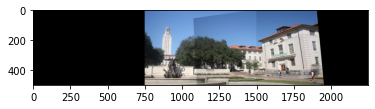

In [23]:
avg = panoramaMosaic2(img1, img2, kpts_method='sift', blending_method='average', 
                         prints=False, two_image_mosaic=True)
show(avg)

Grayscale
Keypoints
Matches
DrawMatches
Homography
Mosaic


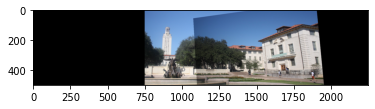

In [24]:
base = panoramaMosaic2(img1, img2, kpts_method='sift', blending_method='base', 
                         prints=False, two_image_mosaic=True)
show(base)

Grayscale
Keypoints
Matches
DrawMatches
Homography
Mosaic


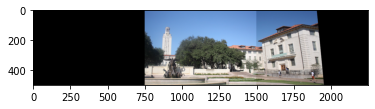

In [25]:
other = panoramaMosaic2(img1, img2, kpts_method='sift', blending_method='other', 
                         prints=False, two_image_mosaic=True)
show(other)

Grayscale
Keypoints
Matches
DrawMatches
Homography
Transform img1
Masks 12
Mosaic


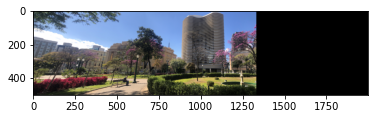

In [35]:
special = panoramaMosaic2Special(img1, img2, kpts_method='sift', prints=False)
show(special)

## Exemplo 2

In [26]:
src1 = 'img1-set1.jpg'
src2 = 'img2-set1.jpg'
src3 = 'img3-set1.jpg'

img1 = cv.imread(src1)
img2 = cv.imread(src2)
img3 = cv.imread(src3)

img1 = image_resize(img1, height=500)
img2 = image_resize(img2, height=500)
img3 = image_resize(img3, height=500)

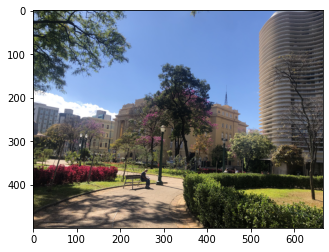

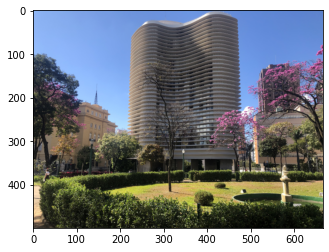

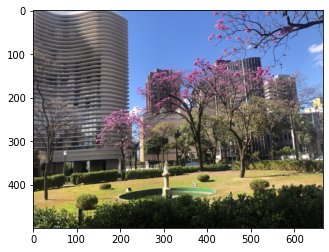

In [27]:
show(img1)
show(img2)
show(img3)

Grayscale
Keypoints
Raw matches (Brute force): 365
Matches


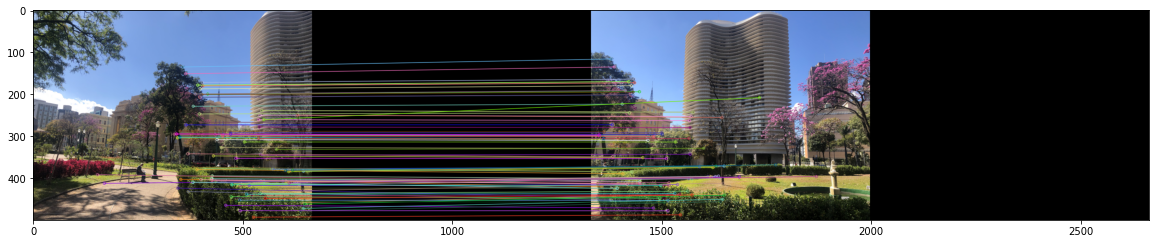

DrawMatches
Homography


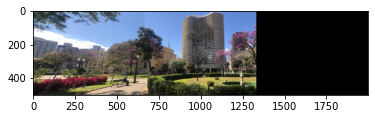

Mosaic
img1->2 done
Grayscale
Keypoints
Raw matches (Brute force): 446
Matches


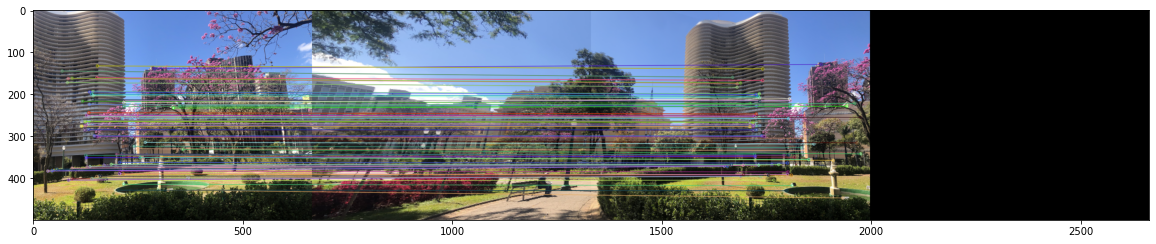

DrawMatches
Homography


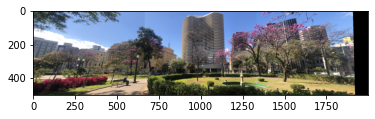

Mosaic
img3->2 done


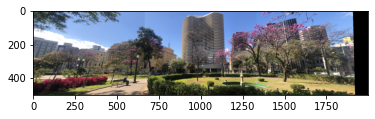

In [28]:
res = panoramaMosaic3(img1, img2, img3, n_kpts=1000, prints=True)
show(res)

Grayscale
Keypoints
Raw matches (Brute force): 365
Raw matches (Brute force): 456
Matches


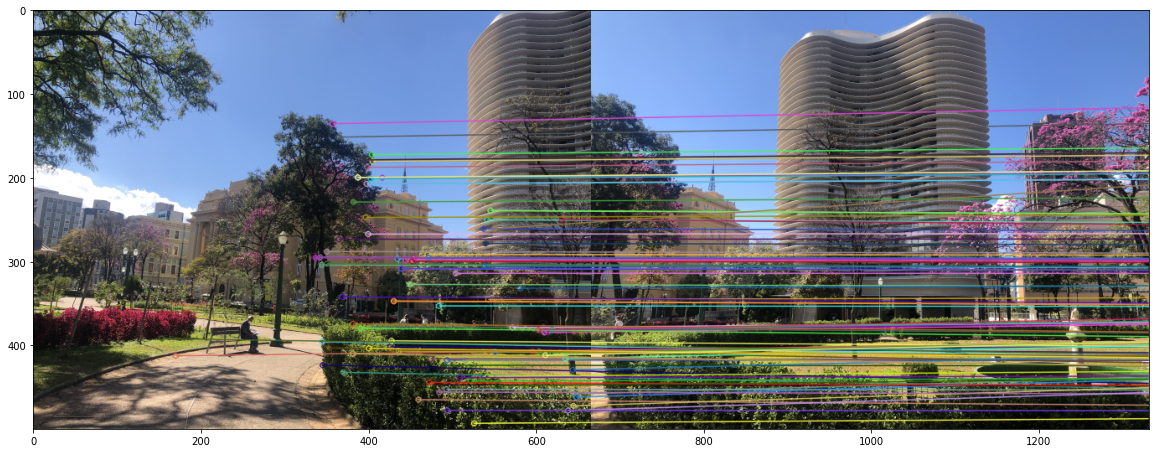

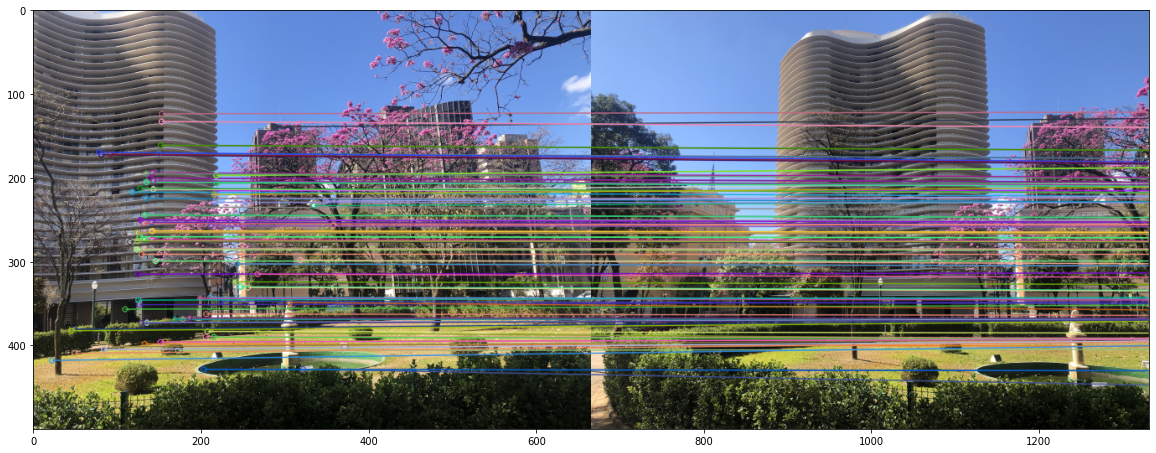

DrawMatches
Homography
Transform img1
Transform img3
Masks 12
Masks 32
Mosaic


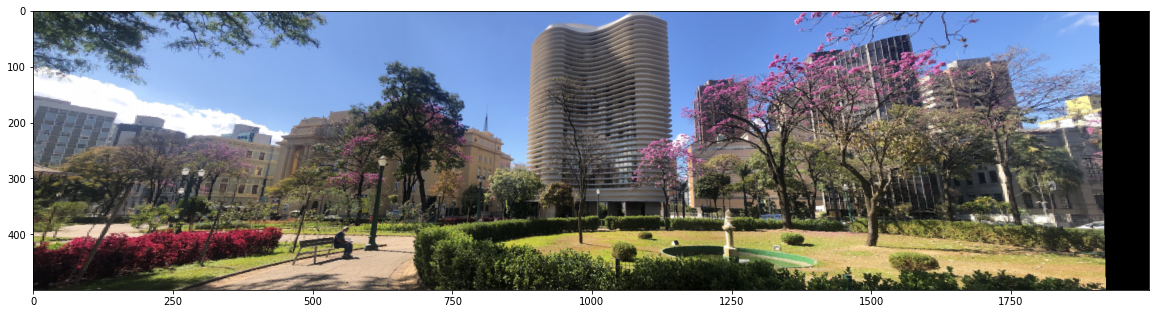

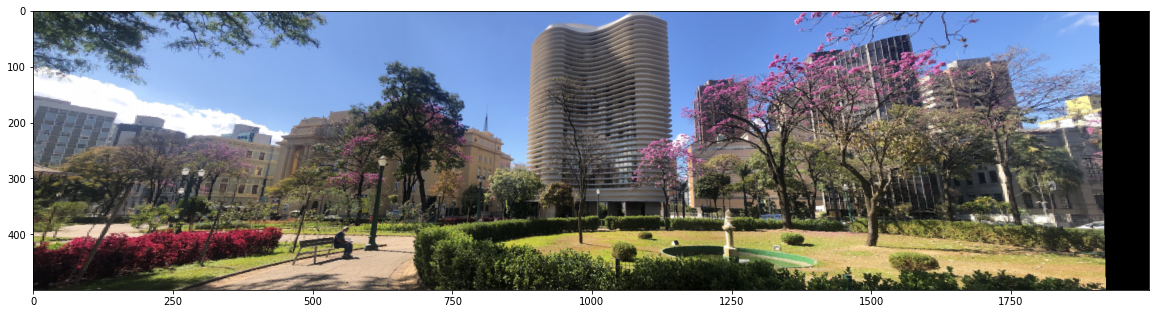

In [36]:
res = panoramaMosaic3Special(img1, img2, img3, n_kpts=1000, prints=True)
plt.figure(figsize=(20,10))
show(res)

- Se a imagem não tiver grandes problemas de vigneting e de iluminação, é mais tranquilo de aguentar a média
- O feathering também, ele não é perfeito, se tiver muita diferença ainda fica com problemas